LL restr.:   -2320.447  rhobar: 0.412  Parameters: 9
LL unrestr.: -2314.574  rhobar: 0.414  Parameters: 10
Likelihood ratio: 11.747
Output files:
boxcox_restricted~09.html
boxcox_unrestricted~09.html


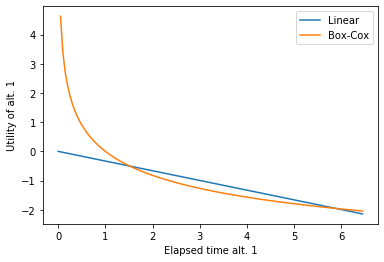

In [3]:
# Translated to .py by Marti Montesinos
# Adapted to PandasBiogeme by Michel Bierlaire
# Tue Oct 23 16:25:20 2018

import pandas as pd
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
from biogeme.expressions import Beta, DefineVariable, log, Elem, Numeric
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("airline.dat",'\t')
database = db.Database("airline",df)
pd.options.display.float_format = '{:.3g}'.format
globals().update(database.variables)


def boxcox(x,l):
	import warnings
	warnings.filterwarnings("ignore")
	return (x**l-1.0)/l


# Exclude
exclude =  (ArrivalTimeHours_1   ==  -1)
database.remove(exclude)
  
# Choice
chosenAlternative = ( (  BestAlternative_1   *  1  ) + (  BestAlternative_2   *  2  ) ) + (  BestAlternative_3   *  3  )

#Parameters to be estimated
# Arguments:
#   1  Name for report. Typically, the same as the variable
#   2  Starting value
#   3  Lower bound
#   4  Upper bound
#   5  0: estimate the parameter, 1: keep it fixed
Constant1	 = Beta('Constant1',0,None,None,1)
Constant2	 = Beta('Constant2',0,None,None,0)
Constant3	 = Beta('Constant3',0,None,None,0)
Fare	 = Beta('Fare',0,None,None,0)
LAMBDA	 = Beta('LAMBDA',1,None,None,0)
Legroom	 = Beta('Legroom',0,None,None,0)
SchedDE	 = Beta('SchedDE',0,None,None,0)
SchedDL	 = Beta('SchedDL',0,None,None,0)
Total_TT1	 = Beta('Total_TT1',0,None,None,0)
Total_TT2	 = Beta('Total_TT2',0,None,None,0)
Total_TT3	 = Beta('Total_TT3',0,None,None,0)

# Define here arithmetic expressions for name that are not directly 
# available from the data

DepartureTimeSensitive  = DefineVariable('DepartureTimeSensitive', q11_DepartureOrArrivalIsImportant   ==  1 ,database)
ArrivalTimeSensitive  = DefineVariable('ArrivalTimeSensitive', q11_DepartureOrArrivalIsImportant   ==  2 ,database)
Missing  = DefineVariable('Missing',(  q11_DepartureOrArrivalIsImportant   !=  1  ) * (  q11_DepartureOrArrivalIsImportant   !=  2  ),database)
DesiredDepartureTime  = DefineVariable('DesiredDepartureTime',q12_IdealDepTime ,database)
DesiredArrivalTime  = DefineVariable('DesiredArrivalTime',q13_IdealArrTime ,database)
ScheduledDelay_1  = DefineVariable('ScheduledDelay_1',(  DepartureTimeSensitive   * (  DepartureTimeMins_1   -  DesiredDepartureTime   ) ) + (  ArrivalTimeSensitive   * (  ArrivalTimeMins_1   -  DesiredArrivalTime   ) ),database)
ScheduledDelay_2  = DefineVariable('ScheduledDelay_2',(  DepartureTimeSensitive   * (  DepartureTimeMins_2   -  DesiredDepartureTime   ) ) + (  ArrivalTimeSensitive   * (  ArrivalTimeMins_2   -  DesiredArrivalTime   ) ),database)
ScheduledDelay_3  = DefineVariable('ScheduledDelay_3',(  DepartureTimeSensitive   * (  DepartureTimeMins_3   -  DesiredDepartureTime   ) ) + (  ArrivalTimeSensitive   * (  ArrivalTimeMins_3   -  DesiredArrivalTime   ) ),database)
Opt1_SchedDelayEarly  = DefineVariable('Opt1_SchedDelayEarly',(  -(ScheduledDelay_1 )  * (  ScheduledDelay_1   <  0  ) ) /  60 ,database)
Opt2_SchedDelayEarly  = DefineVariable('Opt2_SchedDelayEarly',(  -(ScheduledDelay_2 )  * (  ScheduledDelay_2   <  0  ) ) /  60 ,database)
Opt3_SchedDelayEarly  = DefineVariable('Opt3_SchedDelayEarly',(  -(ScheduledDelay_3 )  * (  ScheduledDelay_3   <  0  ) ) /  60 ,database)
Opt1_SchedDelayLate  = DefineVariable('Opt1_SchedDelayLate',(  ScheduledDelay_1   * (  ScheduledDelay_1   >  0  ) ) /  60 ,database)
Opt2_SchedDelayLate  = DefineVariable('Opt2_SchedDelayLate',(  ScheduledDelay_2   * (  ScheduledDelay_2   >  0  ) ) /  60 ,database)
Opt3_SchedDelayLate  = DefineVariable('Opt3_SchedDelayLate',(  ScheduledDelay_3   * (  ScheduledDelay_3   >  0  ) ) /  60 ,database)

av = {1: 1,2: 1,3: 1}

# Utilities restricted model
M1_Opt1 = Constant1 + Fare * Fare_1 + Legroom * Legroom_1 + SchedDE * Opt1_SchedDelayEarly + SchedDL * Opt1_SchedDelayLate +  Total_TT1   * TripTimeHours_1
M1_Opt2 = Constant2 + Fare * Fare_2 + Legroom * Legroom_2 + SchedDE * Opt2_SchedDelayEarly + SchedDL * Opt2_SchedDelayLate + Total_TT2 * TripTimeHours_2
M1_Opt3 = Constant3 + Fare * Fare_3 + Legroom * Legroom_3 + SchedDE * Opt3_SchedDelayEarly + SchedDL * Opt3_SchedDelayLate + Total_TT3 * TripTimeHours_3
M1_V = {1: M1_Opt1,2: M1_Opt2,3: M1_Opt3}
M1_logprob = models.loglogit(M1_V,av,chosenAlternative)


# Utilities unrestricted model
M2_Opt1 = Constant1 + Fare * Fare_1 + Legroom * Legroom_1 + SchedDE * Opt1_SchedDelayEarly + SchedDL * Opt1_SchedDelayLate +  Total_TT1   * boxcox(TripTimeHours_1, LAMBDA)
M2_Opt2 = Constant2 + Fare * Fare_2 + Legroom * Legroom_2 + SchedDE * Opt2_SchedDelayEarly + SchedDL * Opt2_SchedDelayLate + Total_TT2 * TripTimeHours_2
M2_Opt3 = Constant3 + Fare * Fare_3 + Legroom * Legroom_3 + SchedDE * Opt3_SchedDelayEarly + SchedDL * Opt3_SchedDelayLate + Total_TT3 * TripTimeHours_3
M2_V = {1: M2_Opt1,2: M2_Opt2,3: M2_Opt3}
M2_logprob = models.loglogit(M2_V,av,chosenAlternative)

biogeme_M1  = bio.BIOGEME(database,M1_logprob)
biogeme_M1.modelName = "boxcox_restricted"
results_M1 = biogeme_M1.estimate()
ll_M1 = results_M1.data.logLike

biogeme_M2  = bio.BIOGEME(database,M2_logprob)
biogeme_M2.modelName = "boxcox_unrestricted"
results_M2 = biogeme_M2.estimate()
ll_M2 = results_M2.data.logLike

print(f"LL restr.:   {ll_M1:.3f}  rhobar: {results_M1.data.rhoBarSquare:.3f}  Parameters: {results_M1.data.nparam}")
print(f"LL unrestr.: {ll_M2:.3f}  rhobar: {results_M2.data.rhoBarSquare:.3f}  Parameters: {results_M2.data.nparam}")
lr = -2 * (ll_M1 - ll_M2)
print(f"Likelihood ratio: {lr:.3f}")
print("Output files:")
print(f"{results_M1.data.htmlFileName}")
print(f"{results_M2.data.htmlFileName}")



def utilLinear(tt):
    beta = ['Total_TT1']
    betaValue = results_M1.getBetaValues(beta)
    return betaValue['Total_TT1'] * tt 

def utilBoxCox(tt):
    tt_scaled = tt 
    betas = ['Total_TT1','LAMBDA']
    betaValues = results_M2.getBetaValues(betas)
    V = betaValues['Total_TT1'] * boxcox(tt,np.float(betaValues['LAMBDA']))
    return V

travelTime = np.arange(0,6.5,0.05)
vl = [utilLinear(t) for t in travelTime]
vbc = [utilBoxCox(t) for t in travelTime]

fig, ax = plt.subplots()
ax.plot(travelTime,vl,label='Linear')
ax.plot(travelTime,vbc,label='Box-Cox')
ax.legend()
plt.xlabel("Elapsed time alt. 1")
plt.ylabel("Utility of alt. 1")
plt.show()

